# Imports

In [1]:
from model_builder import ModelBuilder
import random
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import colorsys
from scipy.interpolate import splrep, BSpline # for Spline graphs
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
plt.rcParams["font.family"] = "Times New Roman"
import math
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open("config.json", "rb") as json_file:
    config = json.load(json_file)
config

{'becker': {'filename': 'beckerestimation_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'mean_pre_discussion_error',
   'mean_post_discussion_error',
   'mean_pre_discussion_error_pct',
   'mean_post_discussion_error_pct',
   'question',
   'chatrooms',
   'trial_indx']},
 'csop': {'filename': 'csop_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'round_num',
   'round_index',
   'task_index',
   'complexity',
   'type',
   'social_perceptiveness',
   'skill',
   'normalized_score',
   'score',
   'duration',
   'efficiency']},
 'csopII': {'filename': 'csopII_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'batch_num',
   'vis_img',
   'int_verb',
   'ort_img',
   'rep_man',
   'soc_pers',
   'team_size',
   'difficulty',
   'score',
   'duration',
   'efficiency',
   'timestamp']},
 'dat': {'filename': 'DAT_output_conversation_level.csv',
  'cols_to_ignore': ['conversation_num',
   'b

# Per-Task Linear Models
This notebook contains univariate linear models models to show how different independent variables relate to the dependent variable(s) of interest, for each task.


In [54]:
# For manually fitting and visualizing linear models
sns.set_context("paper", rc={"axes.labelsize":20})
sns.set_context("talk", font_scale=1.4)

def plot_single_linear_model(conversation_data, x_vars, y_vars, num_top_plots=None):
    num_plots = len(x_vars) * len(y_vars)
    num_rows = len(y_vars)
    num_cols = len(x_vars)
    num_plots_per_row = min(5, num_cols)

    num_rows_needed = math.ceil(num_plots / num_plots_per_row)
    fig_height = num_rows_needed * 5
    fig_width = num_plots_per_row * 5

    plt.figure(figsize=(fig_width, fig_height))
    
    plot_num = 1    
    all_metrics = []

    for y_var in y_vars:
        for x_var in x_vars:
            x_data = conversation_data[x_var].values.reshape(-1, 1)
            y_data = conversation_data[y_var].values

            # Fit linear regression model
            model = LinearRegression()
            model.fit(x_data, y_data)

            # Predict using the model
            y_pred = model.predict(x_data)

            # Calculate metrics
            r_squared = r2_score(y_data, y_pred)
            mse = mean_squared_error(y_data, y_pred)
            mae = mean_absolute_error(y_data, y_pred)
            all_metrics.append((x_var, y_var, r_squared, mse, mae))
            
            if num_top_plots is None or plot_num <= num_top_plots:
                plt.subplot(num_rows_needed, num_plots_per_row, plot_num)
                sns.scatterplot(x=x_var, y=y_var, data=conversation_data)
                plt.plot(x_data, y_pred, color='red')
                    
                plot_num += 1
                
                if plot_num > num_plots:
                    break
    
    plt.tight_layout()
    plt.show()
    
    metrics_df = pd.DataFrame(all_metrics, columns=['x_var', 'y_var', 'r_squared', 'mse', 'mae']).sort_values(by='r_squared', ascending=False)
    if num_top_plots is not None:
        metrics_df = metrics_df.head(num_top_plots)

    return(metrics_df)

# Example call
# r2_jury_simple_models = plot_single_linear_model(juries_model.conv, juries_model.conv.drop(["target_raw", "target_std"], axis = 1), ["target_std"], num_top_plots=10)

In [4]:
def convert_metrics_dict_to_sorted_df(data):
    # Convert the nested dictionary to a DataFrame
    df = pd.DataFrame(data).T

    # Reset index to move the 'feature' names to a column
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'feature'}, inplace=True)

    # Sort the DataFrame by 'r2' values in descending order
    df_sorted = df.sort_values(by='r2', ascending=False)

    # Reorder the columns as required
    columns_order = ['feature', 'r2', 'mae', 'mse', 'rmse']
    df_sorted = df_sorted[columns_order]
    return(df_sorted)

In [5]:
def repeated_kfold_cv_simplelinear(model, k = 10, seed = 19104):

    # Store metrics --- R^2, MAE, MSE
    metrics = ['r2', 'mae', 'mse', 'rmse']
    feature_metric_dictionary = {}

    # Assumes that we already called split datasets before we called this function!
    all_features = model.X.columns # include all possible features at this stage

    # set up to store results for this feature
    for feature in all_features:
        feature_metric_dictionary[feature] = {"train": None, "test": None}
        feature_metric_dictionary[feature]["train"] = pd.DataFrame(columns=metrics)
        feature_metric_dictionary[feature]["test"] = pd.DataFrame(columns=metrics)

    # Outer loop --- repeat this k times for k-fold CV
    # Repeated k-fold cross-validation
    random.seed(seed) # set seed for reproducibility
    random_states_list = [random.randint(100, 1000000) for _ in range(k)] # create a bunch of different random states

    for i in range(len(random_states_list)):
        # create an entirely different train-test split for each random iteration
        model.get_split_datasets(model.baseline_model, val_size = 0.2, test_size = None, random_state = random_states_list[i])

        # Save X_train, y_train, X_val, and y_val so that we don't have to split anew every time
        X_train = model.X_train
        X_val = model.X_val
        y_train = model.y_train
        y_val = model.y_val
        
        # Fit a single linear regression on each of the features and report the results
        for feature in model.X_train: # do this only for the features that made it into this split
            # train a linear regression on just this one feature
            evaluation_metrics = model.train_simple_model(model.baseline_model, feature_subset = [feature])
            # store the results for that feature
            feature_metric_dictionary[feature]["train"] = feature_metric_dictionary[feature]["train"].append(evaluation_metrics['train'], ignore_index=True)
            feature_metric_dictionary[feature]["test"] = feature_metric_dictionary[feature]["test"].append(evaluation_metrics['val'], ignore_index=True)
            # reset the train-test-split, as the underlying X_test got modified
            model.set_datasets(X_train=X_train, y_train = y_train, X_val = X_val, y_val = y_val)

    # Get mean metrics for each feature
    '''
    Optimal format:

    feature 1    r2   mae   mse  rmse
    feature 2    r2   mae   mse  rmse
    feature 3    r2   mae   mse  rmse
    '''
    final_feature_metrics_train = {}
    final_feature_metrics_test = {}

    for feature in feature_metric_dictionary.keys():
        final_feature_metrics_train[feature]=feature_metric_dictionary[feature]["train"].mean()
        final_feature_metrics_test[feature]=feature_metric_dictionary[feature]["test"].mean()

    return final_feature_metrics_train, final_feature_metrics_test


# Jury

### Full Data (100)%

In [6]:
# Define the basic model
juries_model = ModelBuilder(dataset_names = ["juries"])
juries_model.select_target(target=["majority_pct"])
juries_model.define_model(model_type = 'linear')
juries_model.get_split_datasets(juries_model.baseline_model, val_size = 0.2, test_size = None)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


In [7]:
final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(juries_model)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


In [8]:
jury_train_metrics=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
jury_test_metrics=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

In [9]:
jury_train_metrics.head(10).to_csv('./top_features_from_simple_reg/jury_top_10.csv')

In [10]:
jury_test_metrics.head(10)

,feature,r2,mae,mse,rmse
682,average_user_sum_positivity_zscore_chats,0.05382,0.82843,0.90805,0.95205
3,average_positive_bert,0.05127,0.82797,0.91023,0.95289
291,average_positivity_zscore_chats,0.05127,0.82797,0.91023,0.95289
706,average_user_sum_hashedge,0.05048,0.83199,0.91168,0.95403
684,min_user_sum_positivity_zscore_chats,0.04782,0.83173,0.91415,0.95476
593,max_user_sum_verbs,0.0475,0.83777,0.91449,0.95548
714,average_user_sum_hedges,0.04739,0.83457,0.91489,0.95586
717,max_user_sum_hedges,0.04522,0.83664,0.91665,0.95684
590,average_user_sum_verbs,0.04518,0.8339,0.91593,0.95614
709,max_user_sum_hashedge,0.0447,0.83925,0.91687,0.95698


### 75% of Data

In [11]:
juries_model75 = ModelBuilder(dataset_names = ["juries"], output_dir = '../output/first_75/')
juries_model75.select_target(target=["majority_pct"])
juries_model75.define_model(model_type = 'linear')
juries_model75.get_split_datasets(juries_model75.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(juries_model75)
jury_train_metrics75=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
jury_test_metrics75=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

jury_test_metrics75.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
682,average_user_sum_positivity_zscore_chats,0.05382,0.82843,0.90805,0.95205
706,average_user_sum_hashedge,0.05048,0.83199,0.91168,0.95403
684,min_user_sum_positivity_zscore_chats,0.04782,0.83173,0.91415,0.95476
593,max_user_sum_verbs,0.0475,0.83777,0.91449,0.95548
714,average_user_sum_hedges,0.04739,0.83457,0.91489,0.95586
717,max_user_sum_hedges,0.04522,0.83664,0.91665,0.95684
590,average_user_sum_verbs,0.04518,0.8339,0.91593,0.95614
709,max_user_sum_hashedge,0.0447,0.83925,0.91687,0.95698
610,average_user_sum_cognitive_mech,0.04279,0.83487,0.9195,0.95805
546,average_user_sum_social,0.04209,0.83727,0.91865,0.95777


In [12]:
jury_train_metrics75.head(10).to_csv('./top_features_from_simple_reg/jury75_top_10.csv')

### 50% Data

In [13]:
juries_model50 = ModelBuilder(dataset_names = ["juries"], output_dir = '../output/first_50/')
juries_model50.select_target(target=["majority_pct"])
juries_model50.define_model(model_type = 'linear')
juries_model50.get_split_datasets(juries_model50.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(juries_model50)
jury_train_metrics50=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
jury_test_metrics50=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

jury_test_metrics50.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
682,average_user_sum_positivity_zscore_chats,0.05382,0.82843,0.90805,0.95205
706,average_user_sum_hashedge,0.05048,0.83199,0.91168,0.95403
684,min_user_sum_positivity_zscore_chats,0.04782,0.83173,0.91415,0.95476
593,max_user_sum_verbs,0.0475,0.83777,0.91449,0.95548
714,average_user_sum_hedges,0.04739,0.83457,0.91489,0.95586
717,max_user_sum_hedges,0.04522,0.83664,0.91665,0.95684
590,average_user_sum_verbs,0.04518,0.8339,0.91593,0.95614
709,max_user_sum_hashedge,0.0447,0.83925,0.91687,0.95698
610,average_user_sum_cognitive_mech,0.04279,0.83487,0.9195,0.95805
546,average_user_sum_social,0.04209,0.83727,0.91865,0.95777


In [14]:
jury_train_metrics50.head(10).to_csv('./top_features_from_simple_reg/jury50_top_10.csv')

### 25% of Data

In [15]:
juries_model25 = ModelBuilder(dataset_names = ["juries"], output_dir = '../output/first_25/')
juries_model25.select_target(target=["majority_pct"])
juries_model25.define_model(model_type = 'linear')
juries_model25.get_split_datasets(juries_model25.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(juries_model25)
jury_train_metrics25=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
jury_test_metrics25=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

jury_test_metrics25.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
682,average_user_sum_positivity_zscore_chats,0.05382,0.82843,0.90805,0.95205
706,average_user_sum_hashedge,0.05048,0.83199,0.91168,0.95403
684,min_user_sum_positivity_zscore_chats,0.04782,0.83173,0.91415,0.95476
593,max_user_sum_verbs,0.0475,0.83777,0.91449,0.95548
714,average_user_sum_hedges,0.04739,0.83457,0.91489,0.95586
717,max_user_sum_hedges,0.04522,0.83664,0.91665,0.95684
590,average_user_sum_verbs,0.04518,0.8339,0.91593,0.95614
709,max_user_sum_hashedge,0.0447,0.83925,0.91687,0.95698
610,average_user_sum_cognitive_mech,0.04279,0.83487,0.9195,0.95805
546,average_user_sum_social,0.04209,0.83727,0.91865,0.95777


In [16]:
jury_train_metrics25.head(10).to_csv('./top_features_from_simple_reg/jury25_top_10.csv')

# CSOP (blended)

### Full Data (100%)

In [17]:
csop_blended_model = ModelBuilder(dataset_names = ["csop", "csopII"])
csop_blended_model.select_target(target=["efficiency", "efficiency"])
csop_blended_model.define_model(model_type = 'linear')
csop_blended_model.get_split_datasets(csop_blended_model.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(csop_blended_model)
csop_blended_train_metrics=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
csop_blended_test_metrics=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

csop_blended_test_metrics.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
402,average_user_sum_num_words,0.22757,0.64562,0.75387,0.86595
406,average_user_sum_num_chars,0.22327,0.65042,0.75815,0.86837
634,average_user_sum_nltk_english_stopwords,0.22145,0.64854,0.7596,0.86928
405,max_user_sum_num_words,0.21537,0.64764,0.765,0.87254
409,max_user_sum_num_chars,0.21188,0.65361,0.76868,0.87459
637,max_user_sum_nltk_english_stopwords,0.20628,0.65418,0.77366,0.87748
602,average_user_sum_auxiliary_verbs,0.20558,0.66309,0.77652,0.87856
586,average_user_sum_verbs,0.2048,0.65748,0.77611,0.87859
589,max_user_sum_verbs,0.1991,0.65392,0.78056,0.88135
610,average_user_sum_preposition,0.19571,0.66016,0.78536,0.8837


In [18]:
csop_blended_train_metrics.head(10).to_csv('./top_features_from_simple_reg/csop_top_10.csv')

### 75% Data

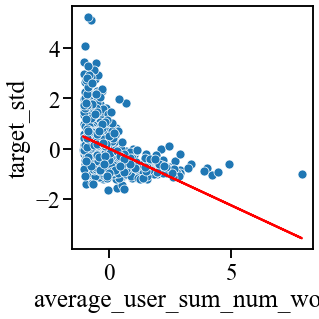

,x_var,y_var,r_squared,mse,mae
0,average_user_sum_num_words,target_std,0.204172,0.795828,0.661502


In [ ]:
# look at some correlations
sns.pairplot(csop_blended_model.conv, )

In [19]:
csop_blended_model75 = ModelBuilder(dataset_names = ["csop", "csopII"], output_dir = '../output/first_75/')
csop_blended_model75.select_target(target=["efficiency", "efficiency"])
csop_blended_model75.define_model(model_type = 'linear')
csop_blended_model75.get_split_datasets(csop_blended_model75.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(csop_blended_model75)
csop_blended_train_metrics75=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
csop_blended_test_metrics75=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

csop_blended_test_metrics75.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
402,average_user_sum_num_words,0.22757,0.64562,0.75387,0.86595
406,average_user_sum_num_chars,0.22327,0.65042,0.75815,0.86837
634,average_user_sum_nltk_english_stopwords,0.22145,0.64854,0.7596,0.86928
405,max_user_sum_num_words,0.21537,0.64764,0.765,0.87254
409,max_user_sum_num_chars,0.21188,0.65361,0.76868,0.87459
637,max_user_sum_nltk_english_stopwords,0.20628,0.65418,0.77366,0.87748
602,average_user_sum_auxiliary_verbs,0.20558,0.66309,0.77652,0.87856
586,average_user_sum_verbs,0.2048,0.65748,0.77611,0.87859
589,max_user_sum_verbs,0.1991,0.65392,0.78056,0.88135
610,average_user_sum_preposition,0.19571,0.66016,0.78536,0.8837


In [20]:
csop_blended_train_metrics75.head(10).to_csv('./top_features_from_simple_reg/csop75_top_10.csv')

### 50% Data

In [21]:
csop_blended_model50 = ModelBuilder(dataset_names = ["csop", "csopII"], output_dir = '../output/first_50/')
csop_blended_model50.select_target(target=["efficiency", "efficiency"])
csop_blended_model50.define_model(model_type = 'linear')
csop_blended_model50.get_split_datasets(csop_blended_model50.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(csop_blended_model50)
csop_blended_train_metrics50=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
csop_blended_test_metrics50=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

csop_blended_test_metrics50.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
402,average_user_sum_num_words,0.22757,0.64562,0.75387,0.86595
406,average_user_sum_num_chars,0.22327,0.65042,0.75815,0.86837
634,average_user_sum_nltk_english_stopwords,0.22145,0.64854,0.7596,0.86928
405,max_user_sum_num_words,0.21537,0.64764,0.765,0.87254
409,max_user_sum_num_chars,0.21188,0.65361,0.76868,0.87459
637,max_user_sum_nltk_english_stopwords,0.20628,0.65418,0.77366,0.87748
602,average_user_sum_auxiliary_verbs,0.20558,0.66309,0.77652,0.87856
586,average_user_sum_verbs,0.2048,0.65748,0.77611,0.87859
589,max_user_sum_verbs,0.1991,0.65392,0.78056,0.88135
610,average_user_sum_preposition,0.19571,0.66016,0.78536,0.8837


In [22]:
csop_blended_train_metrics50.head(10).to_csv('./top_features_from_simple_reg/csop50_top_10.csv')

### 25% Data

In [23]:
csop_blended_model25 = ModelBuilder(dataset_names = ["csop", "csopII"], output_dir = '../output/first_25/')
csop_blended_model25.select_target(target=["efficiency", "efficiency"])
csop_blended_model25.define_model(model_type = 'linear')
csop_blended_model25.get_split_datasets(csop_blended_model25.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(csop_blended_model25)
csop_blended_train_metrics25=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
csop_blended_test_metrics25=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

csop_blended_test_metrics25.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
402,average_user_sum_num_words,0.22757,0.64562,0.75387,0.86595
406,average_user_sum_num_chars,0.22327,0.65042,0.75815,0.86837
634,average_user_sum_nltk_english_stopwords,0.22145,0.64854,0.7596,0.86928
405,max_user_sum_num_words,0.21537,0.64764,0.765,0.87254
409,max_user_sum_num_chars,0.21188,0.65361,0.76868,0.87459
637,max_user_sum_nltk_english_stopwords,0.20628,0.65418,0.77366,0.87748
602,average_user_sum_auxiliary_verbs,0.20558,0.66309,0.77652,0.87856
586,average_user_sum_verbs,0.2048,0.65748,0.77611,0.87859
589,max_user_sum_verbs,0.1991,0.65392,0.78056,0.88135
610,average_user_sum_preposition,0.19571,0.66016,0.78536,0.8837


In [24]:
csop_blended_train_metrics25.head(10).to_csv('./top_features_from_simple_reg/csop25_top_10.csv')

# DAT

### Full data (100%)

In [25]:
dat_model = ModelBuilder(dataset_names = ["dat"])
dat_model.select_target(target=["efficiency"])
dat_model.define_model(model_type = 'linear')
dat_model.get_split_datasets(dat_model.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(dat_model)
dat_train_metrics=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
dat_test_metrics=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

dat_test_metrics.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
396,min_user_sum_positive_bert,0.080767,0.779433,1.003467,0.994178
472,min_user_sum_negation,0.06183,0.80798,1.05772,1.02161
860,min_user_avg_negation,0.05877,0.79983,1.06019,1.02315
718,average_user_sum_factuality,0.05635,0.7947,1.05999,1.02202
744,min_user_sum_1st_person_start,0.046113,0.807787,1.032787,1.004725
768,min_user_sum_haspositive,0.024711,0.816211,1.060133,1.024056
600,min_user_sum_article,0.0222,0.808733,1.075678,1.027856
327,average_factuality,0.01355,0.81381,1.11196,1.04797
508,min_user_sum_positive_affect,0.010738,0.812262,1.050812,1.019462
632,min_user_sum_positive_words,0.009789,0.816467,1.098056,1.041378


In [26]:
dat_train_metrics.head(10).to_csv('./top_features_from_simple_reg/dat_top_10.csv')

### 75% Data

In [27]:
dat_model75 = ModelBuilder(dataset_names = ["dat"], output_dir = '../output/first_75/')
dat_model75.select_target(target=["efficiency"])
dat_model75.define_model(model_type = 'linear')
dat_model75.get_split_datasets(dat_model75.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(dat_model75)
dat_train_metrics75=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
dat_test_metrics75=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

dat_test_metrics75.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
396,min_user_sum_positive_bert,0.080767,0.779433,1.003467,0.994178
472,min_user_sum_negation,0.06183,0.80798,1.05772,1.02161
860,min_user_avg_negation,0.05877,0.79983,1.06019,1.02315
718,average_user_sum_factuality,0.05635,0.7947,1.05999,1.02202
744,min_user_sum_1st_person_start,0.046113,0.807787,1.032787,1.004725
12,stdev_neutral_bert,0.027744,0.798578,1.068422,1.0245
768,min_user_sum_haspositive,0.024711,0.816211,1.060133,1.024056
4,stdev_positive_bert,0.022544,0.8036,1.073333,1.027189
292,stdev_positivity_zscore_chats,0.022544,0.8036,1.073333,1.027189
600,min_user_sum_article,0.0222,0.808733,1.075678,1.027856


In [28]:
dat_train_metrics75.head(10).to_csv('./top_features_from_simple_reg/dat75_top_10.csv')

### 50% Data

In [29]:
dat_model50 = ModelBuilder(dataset_names = ["dat"], output_dir = '../output/first_50/')
dat_model50.select_target(target=["efficiency"])
dat_model50.define_model(model_type = 'linear')

dat_model50.get_split_datasets(dat_model50.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(dat_model50)
dat_train_metrics50=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
dat_test_metrics50=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

dat_test_metrics50.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
396,min_user_sum_positive_bert,0.080767,0.779433,1.003467,0.994178
472,min_user_sum_negation,0.06183,0.80798,1.05772,1.02161
860,min_user_avg_negation,0.05877,0.79983,1.06019,1.02315
718,average_user_sum_factuality,0.05635,0.7947,1.05999,1.02202
744,min_user_sum_1st_person_start,0.046113,0.807787,1.032787,1.004725
216,stdev_auxiliary_verbs,0.03146,0.78241,1.10917,1.04255
768,min_user_sum_haspositive,0.024711,0.816211,1.060133,1.024056
600,min_user_sum_article,0.0222,0.808733,1.075678,1.027856
508,min_user_sum_positive_affect,0.010738,0.812262,1.050812,1.019462
632,min_user_sum_positive_words,0.009789,0.816467,1.098056,1.041378


In [30]:
dat_train_metrics50.head(10).to_csv('./top_features_from_simple_reg/dat50_top_10.csv')

### 25% Data

In [31]:
dat_model25 = ModelBuilder(dataset_names = ["dat"], output_dir = '../output/first_25/')
dat_model25.select_target(target=["efficiency"])
dat_model25.define_model(model_type = 'linear')

dat_model25.get_split_datasets(dat_model25.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(dat_model25)
dat_train_metrics25=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
dat_test_metrics25=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

dat_test_metrics25.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
396,min_user_sum_positive_bert,0.080767,0.779433,1.003467,0.994178
472,min_user_sum_negation,0.06183,0.80798,1.05772,1.02161
860,min_user_avg_negation,0.05877,0.79983,1.06019,1.02315
718,average_user_sum_factuality,0.05635,0.7947,1.05999,1.02202
744,min_user_sum_1st_person_start,0.046113,0.807787,1.032787,1.004725
768,min_user_sum_haspositive,0.024711,0.816211,1.060133,1.024056
600,min_user_sum_article,0.0222,0.808733,1.075678,1.027856
508,min_user_sum_positive_affect,0.010738,0.812262,1.050812,1.019462
632,min_user_sum_positive_words,0.009789,0.816467,1.098056,1.041378
541,max_user_sum_inhibition,0.00594,0.82132,1.13007,1.05434


In [32]:
dat_train_metrics25.head(10).to_csv('./top_features_from_simple_reg/dat25_top_10.csv')

# Estimation

### Full Data (100%)

In [33]:
estimation_blended_model = ModelBuilder(dataset_names = ["gurcay", "becker"])
estimation_blended_model.select_target(target=["mean_post_discussion_error_pct", "mean_post_discussion_error_pct"])
estimation_blended_model.define_model(model_type = 'linear')

estimation_blended_model.get_split_datasets(estimation_blended_model.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(estimation_blended_model)
estimation_blended_train_metrics=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
estimation_blended_test_metrics=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

estimation_blended_test_metrics.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
930,average_user_avg_indefinite_pronoun,-0.02705,0.49415,4.1808,2.0447
721,max_user_sum_gratitude,-0.0271,0.50045,4.18115,2.04475
334,max_gratitude,-0.0271,0.50045,4.18115,2.04475
742,average_user_sum_2nd_person_start,-0.0276,0.4976,4.1812,2.0448
254,max_hedge_words,-0.02765,0.4933,4.18325,2.0453
822,average_user_avg_certainty,-0.02805,0.5005,4.1849,2.0457
1105,max_user_avg_gratitude,-0.0283,0.4941,4.184,2.0455
871,stdev_user_avg_body,-0.0288,0.491,4.1858,2.0459
870,average_user_avg_body,-0.0291,0.4898,4.1873,2.0463
294,max_positivity_zscore_chats,-0.0291,0.4946,4.1892,2.0468


In [34]:
estimation_blended_train_metrics.head(10).to_csv('./top_features_from_simple_reg/estimation_top_10.csv')

### 75% Data

In [35]:
estimation_blended_model75 = ModelBuilder(dataset_names = ["gurcay", "becker"],  output_dir = '../output/first_75/')
estimation_blended_model75.select_target(target=["mean_post_discussion_error_pct", "mean_post_discussion_error_pct"])
estimation_blended_model75.define_model(model_type = 'linear')

estimation_blended_model75.get_split_datasets(estimation_blended_model75.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(estimation_blended_model75)
estimation_blended_train_metrics75=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
estimation_blended_test_metrics75=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

estimation_blended_test_metrics75.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
930,average_user_avg_indefinite_pronoun,-0.02705,0.49415,4.1808,2.0447
721,max_user_sum_gratitude,-0.0271,0.50045,4.18115,2.04475
334,max_gratitude,-0.0275,0.4992,4.18265,2.04515
742,average_user_sum_2nd_person_start,-0.0276,0.4976,4.1812,2.0448
822,average_user_avg_certainty,-0.02805,0.5005,4.1849,2.0457
234,max_percept,-0.0282,0.4941,4.1835,2.0454
1105,max_user_avg_gratitude,-0.0283,0.4941,4.184,2.0455
356,stdev_2nd_person_start,-0.0285,0.4995,4.1848,2.0457
871,stdev_user_avg_body,-0.0288,0.491,4.1858,2.0459
870,average_user_avg_body,-0.0291,0.4898,4.1873,2.0463


In [36]:
estimation_blended_train_metrics75.head(10).to_csv('./top_features_from_simple_reg/estimation75_top_10.csv')

### 50% Data

In [37]:
estimation_blended_model50 = ModelBuilder(dataset_names = ["gurcay", "becker"],  output_dir = '../output/first_50/')
estimation_blended_model50.select_target(target=["mean_post_discussion_error_pct", "mean_post_discussion_error_pct"])
estimation_blended_model50.define_model(model_type = 'linear')

estimation_blended_model50.get_split_datasets(estimation_blended_model50.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(estimation_blended_model50)
estimation_blended_train_metrics50=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
estimation_blended_test_metrics50=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

estimation_blended_test_metrics50.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
74,max_anxiety,-0.02495,0.49085,4.17225,2.0426
152,stdev_sadness,-0.0262,0.50015,4.1775,2.0439
59,average_bio,-0.0269,0.4891,4.1781,2.044
930,average_user_avg_indefinite_pronoun,-0.02705,0.49415,4.1808,2.0447
721,max_user_sum_gratitude,-0.0271,0.50045,4.18115,2.04475
208,stdev_article,-0.0271,0.4856,4.183,2.0452
146,max_sexual,-0.02755,0.4958,4.183,2.04525
742,average_user_sum_2nd_person_start,-0.0276,0.4976,4.1812,2.0448
84,stdev_swear,-0.02765,0.5081,4.18315,2.04525
106,max_family,-0.0279,0.5064,4.1824,2.0451


In [38]:
estimation_blended_train_metrics50.head(10).to_csv('./top_features_from_simple_reg/estimation50_top_10.csv')

### 25% Data

In [39]:
estimation_blended_model25 = ModelBuilder(dataset_names = ["gurcay", "becker"],  output_dir = '../output/first_25/')
estimation_blended_model25.select_target(target=["mean_post_discussion_error_pct", "mean_post_discussion_error_pct"])
estimation_blended_model25.define_model(model_type = 'linear')

estimation_blended_model25.get_split_datasets(estimation_blended_model25.baseline_model, val_size = 0.2, test_size = None)

final_feature_metrics_train,final_feature_metrics_test=repeated_kfold_cv_simplelinear(estimation_blended_model25)
estimation_blended_train_metrics25=convert_metrics_dict_to_sorted_df(final_feature_metrics_train)
estimation_blended_test_metrics25=convert_metrics_dict_to_sorted_df(final_feature_metrics_test)

estimation_blended_test_metrics25.head(10)

Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done
Checking Holdout Sets...Creating Holdout Sets...
Cleaning Up Columns...
Done


,feature,r2,mae,mse,rmse
930,average_user_avg_indefinite_pronoun,-0.02705,0.49415,4.1808,2.0447
138,max_past_tense,-0.0271,0.5009,4.1831,2.0453
721,max_user_sum_gratitude,-0.0271,0.50045,4.18115,2.04475
182,max_anger,-0.0273,0.4984,4.1798,2.0445
742,average_user_sum_2nd_person_start,-0.0276,0.4976,4.1812,2.0448
822,average_user_avg_certainty,-0.02805,0.5005,4.1849,2.0457
1105,max_user_avg_gratitude,-0.0283,0.4941,4.184,2.0455
74,max_anxiety,-0.0286,0.4786,4.1853,2.0458
871,stdev_user_avg_body,-0.0288,0.491,4.1858,2.0459
146,max_sexual,-0.029,0.495,4.18875,2.04665


In [40]:
estimation_blended_train_metrics25.head(10).to_csv('./top_features_from_simple_reg/estimation25_top_10.csv')